# Chargement des packages

In [82]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import HistGradientBoostingRegressor
import xgboost as xgb
from catboost import CatBoostRegressor
import lightgbm as lgb
from elasticsearch import Elasticsearch
from elasticsearch.helpers import scan
import warnings
from sklearn.preprocessing import StandardScaler
from elasticsearch import ElasticsearchWarning


# Base de données financière de polygon.io

Ce projet utilise des données financières en temps réel issues de l’API **Polygon.io**, une plateforme qui fournit des flux de données boursières (actions, crypto, etc.).  
Ces données contiennent des informations précieuses sur les transactions de titres financiers, utilisées ici pour construire un pipeline de traitement et de prédiction dans le cadre d’une **architecture Kappa**.

---

## Contexte du projet

- **École** : École supérieure d'informatique  
- **Niveau** : Master II – Science de Données  
- **Cours** : Machine Learning et Big Data  
- **Titre du projet** : Créer un pipe basé sur l’architecture Kappa  

---

## Objectifs du projet

L’objectif du projet est de :

1. **Collecter des données financières en temps réel depuis polygon.io** ;
2. **Créer un pipeline Kappa** :  
   - **Ingestion** (*stream layer*)  
   - **Stockage** (*serving layer via Elasticsearch*)  
   - **Analyse** (*machine learning*) ;
3. **Construire un modèle de prédiction** pour estimer le **prix de clôture (`closePrice`)** en fonction du **volume (`volume`)**.

---

## Contenu de la base de données

La base de données contient les colonnes suivantes (parmi les plus pertinentes pour le modèle) :

- `symbol` : symbole de l’action ou du titre (ex. AAPL, MSFT)  
- `timestamp` : horodatage de la transaction  
- `openPrice` : prix d’ouverture  
- `closePrice` : prix de clôture (**cible du modèle**)  
- `highPrice` : prix le plus élevé observé  
- `lowPrice` : prix le plus bas observé  
- `numberOfTrades` : nombre de transactions  
- `volume` : volume échangé  
- `volumeWeightedAveragePrice` : prix moyen pondéré par le volume


# Connexion à Elasticsearch

In [83]:
# Création d'une instance du client Elasticsearch, en se connectant au serveur local
client = Elasticsearch("http://localhost:9200/")

warnings.filterwarnings("ignore", category=ElasticsearchWarning)

# Requête Elasticsearch : Extraction de toutes les données indexées

Une fois la connexion établie avec Elasticsearch, nous pouvons interroger l’index **results** pour récupérer les données stockées.  
Dans ce projet, nous utilisons une requête de type **match_all** afin d’extraire l'ensemble des documents présents dans l’index.

Nous spécifions également une taille maximale de **10 000 documents**, qui est la limite maximale autorisée par Elasticsearch pour une seule requête, afin d’éviter que la limite par défaut (souvent 10) ne tronque les résultats.


In [100]:
# Initialisation du scroll
scroll_time = "2m"  # durée de validité du scroll
batch_size = 1000   # nombre de documents par lot
index_name = "results"

# Première requête scroll
resp = client.search(
    index=index_name,
    scroll=scroll_time,
    size=batch_size,
    query={"match_all": {}}
)

scroll_id = resp["_scroll_id"]
all_docs = [doc["_source"] for doc in resp["hits"]["hits"]]

# Boucle pour récupérer tous les autres lots
while True:
    resp = client.scroll(scroll_id=scroll_id, scroll=scroll_time)
    hits = resp["hits"]["hits"]
    if not hits:
        break
    all_docs.extend([doc["_source"] for doc in hits])

In [101]:
# Transformation en DataFrame
df = pd.DataFrame(all_docs)
df

,_class,id,symbol,closePrice,highPrice,lowPrice,numberOfTrades,openPrice,timestamp,volume,volumeWeightedAveragePrice
0,unb.esi.bigdataml.model.Result,NYC1715284800000,NYC,8.200000,8.320000,7.948800,121.0,8.040000,1715284800000,5722.0,8.1497
1,unb.esi.bigdataml.model.Result,HCSG1715284800000,HCSG,11.200000,11.200000,10.825000,6950.0,10.990000,1715284800000,469604.0,11.0463
2,unb.esi.bigdataml.model.Result,AVDV1715284800000,AVDV,66.740000,66.810000,66.220000,2400.0,66.230000,1715284800000,297458.0,66.6092
3,unb.esi.bigdataml.model.Result,WULF1715284800000,WULF,2.360000,2.395900,2.260000,12523.0,2.300000,1715284800000,6846143.0,2.3331
4,unb.esi.bigdataml.model.Result,TRMB1715284800000,TRMB,56.780000,57.030000,56.440000,23003.0,56.550000,1715284800000,1286629.0,56.7996
...,...,...,...,...,...,...,...,...,...,...,...
54839,unb.esi.bigdataml.model.Result,ZIEXT1749153600000,ZIEXT,1.000000,1.000000,0.988436,8.0,1.000000,1749153600000,2391.0,1.0034
54840,unb.esi.bigdataml.model.Result,ZTST1749153600000,ZTST,40.170000,40.170000,40.170000,NaN,40.170000,1749153600000,0.0,NaN
54841,unb.esi.bigdataml.model.Result,ZVV1749153600000,ZVV,25.156291,25.156291,25.156291,6.0,25.156291,1749153600000,4542.0,25.3825
54842,unb.esi.bigdataml.model.Result,ZZK1749153600000,ZZK,24.751438,24.751438,24.680985,9.0,24.751438,1749153600000,17577.0,24.8747


In [86]:
# Affichage des informations générales sur le DataFrame
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54844 entries, 0 to 54843
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   _class                      54844 non-null  object 
 1   id                          54844 non-null  object 
 2   symbol                      54844 non-null  object 
 3   closePrice                  54844 non-null  float64
 4   highPrice                   54844 non-null  float64
 5   lowPrice                    54844 non-null  float64
 6   numberOfTrades              54415 non-null  float64
 7   openPrice                   54844 non-null  float64
 8   timestamp                   54844 non-null  int64  
 9   volume                      54844 non-null  float64
 10  volumeWeightedAveragePrice  54415 non-null  float64
dtypes: float64(7), int64(1), object(3)
memory usage: 4.6+ MB


## Description des données

In [47]:
# Affichage des statistiques descriptives du DataFrame
df.describe()

,closePrice,highPrice,lowPrice,numberOfTrades,openPrice,timestamp,volume,volumeWeightedAveragePrice
count,5.484400e+04,5.484400e+04,5.484400e+04,5.441500e+04,5.484400e+04,5.484400e+04,5.484400e+04,5.441500e+04
mean,7.118626e+03,8.486866e+03,6.855106e+03,8.605564e+03,7.796961e+03,1.742605e+12,1.352931e+06,7.675431e+03
std,1.639723e+06,1.959976e+06,1.578234e+06,3.953437e+04,1.798568e+06,1.324344e+10,8.782072e+06,1.763127e+06
min,1.900000e-03,2.000000e-03,1.600000e-03,1.000000e+00,1.700000e-03,1.715285e+12,0.000000e+00,1.757000e-03
25%,8.820000e+00,9.020000e+00,8.600000e+00,8.300000e+01,8.800000e+00,1.748894e+12,9.040500e+03,8.666300e+00
50%,2.398000e+01,2.410100e+01,2.381000e+01,5.970000e+02,2.395005e+01,1.748981e+12,7.764150e+04,2.385500e+01
75%,4.307000e+01,4.337000e+01,4.263000e+01,6.564500e+03,4.300000e+01,1.749067e+12,5.683195e+05,4.302295e+01
max,3.840000e+08,4.590000e+08,3.696000e+08,4.540980e+06,4.212000e+08,1.749154e+12,6.261060e+08,4.112820e+08


In [48]:
# Affichage du nombre de valeurs uniques pour chaque variable
print(df.nunique())

_class                            1
id                            54844
symbol                        12376
closePrice                    24192
highPrice                     25866
lowPrice                      25379
numberOfTrades                16606
openPrice                     19275
timestamp                         5
volume                        45370
volumeWeightedAveragePrice    51698
dtype: int64


In [49]:
# Affichage du nombre de valeurs manquantes pour chaque variable
print(df.isnull().sum())

_class                          0
id                              0
symbol                          0
closePrice                      0
highPrice                       0
lowPrice                        0
numberOfTrades                429
openPrice                       0
timestamp                       0
volume                          0
volumeWeightedAveragePrice    429
dtype: int64


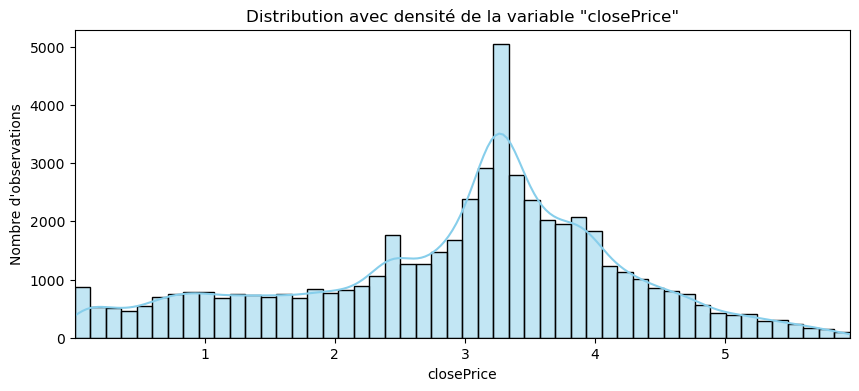

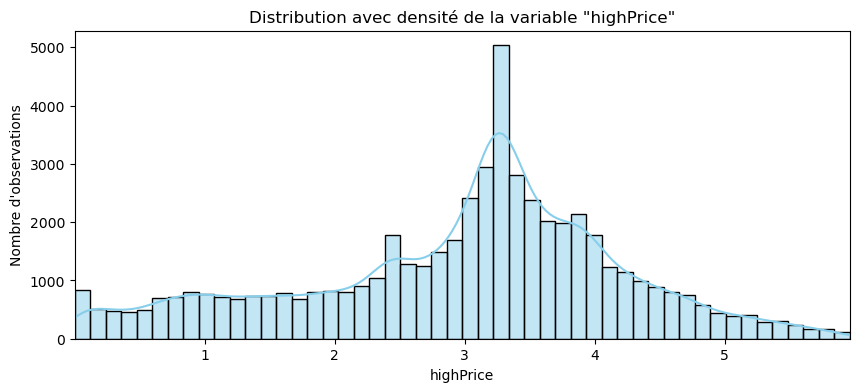

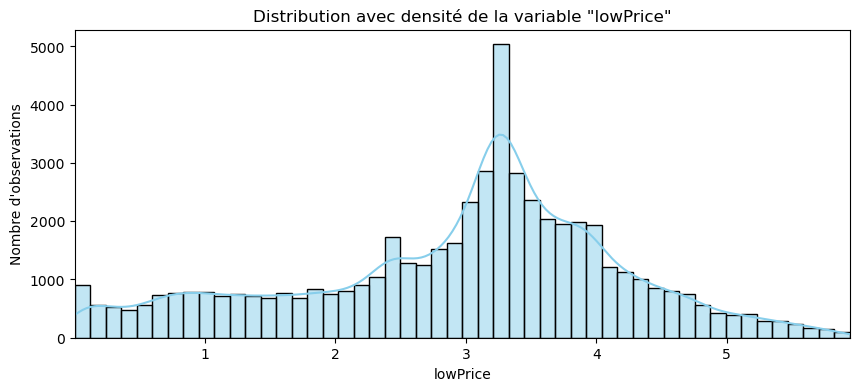

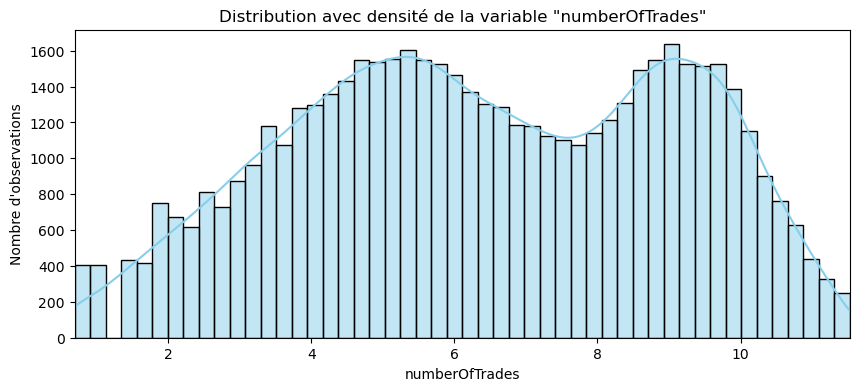

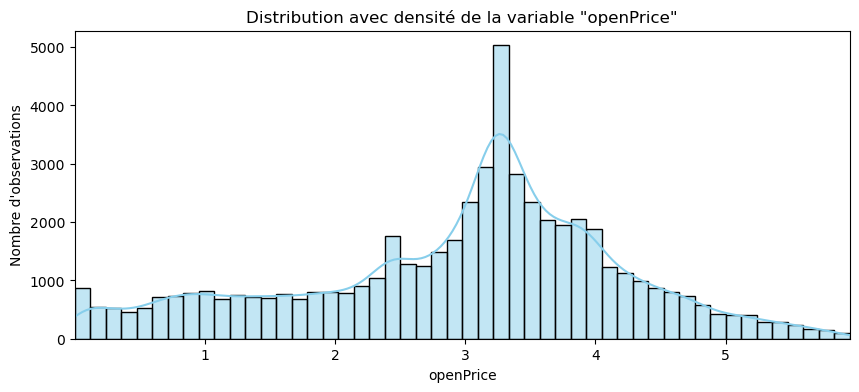

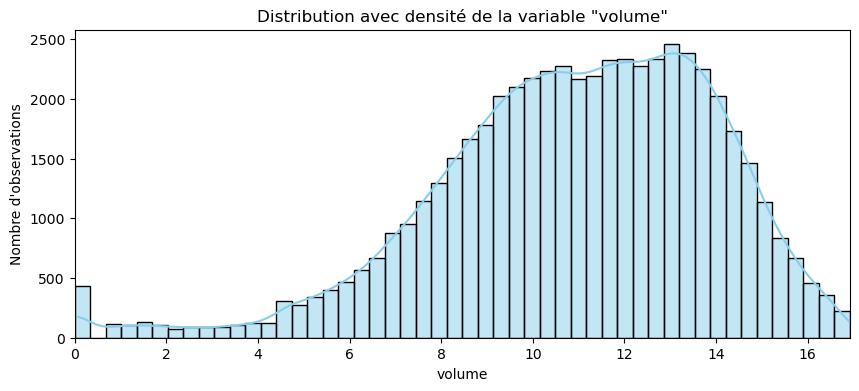

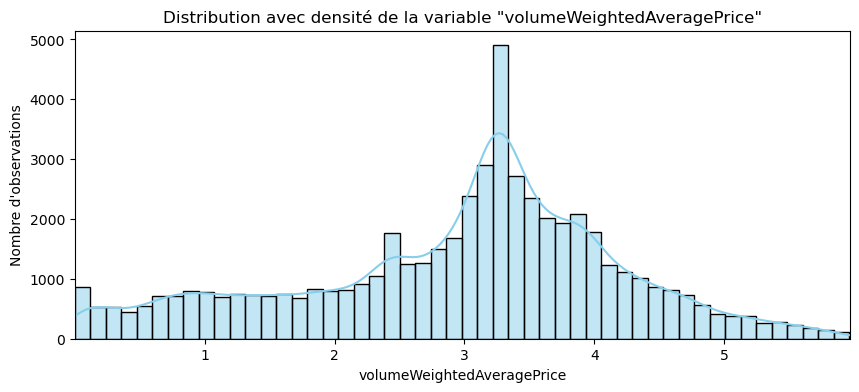

In [50]:
# Génération de la distribution pour chaque variable numérique sur des graphiques séparés
variables = [
    'closePrice',
    'highPrice',
    'lowPrice',
    'numberOfTrades',
    'openPrice',
    'volume',
    'volumeWeightedAveragePrice'
]

for col in variables:
    data_log = np.log1p(df[col])
    
    # Calculer la limite supérieure à 99ème percentile pour limiter les outliers
    x_max = data_log.quantile(0.99)
    
    plt.figure(figsize=(10, 4))
    sns.histplot(data_log[data_log <= x_max], bins=50, kde=True, color='skyblue', edgecolor='black')
    plt.title(f'Distribution avec densité de la variable "{col}"')
    plt.xlabel(f'{col}')
    plt.ylabel("Nombre d'observations")
    plt.xlim(left=data_log.min(), right=x_max)  # Ajuste la limite x automatiquement
    plt.show()


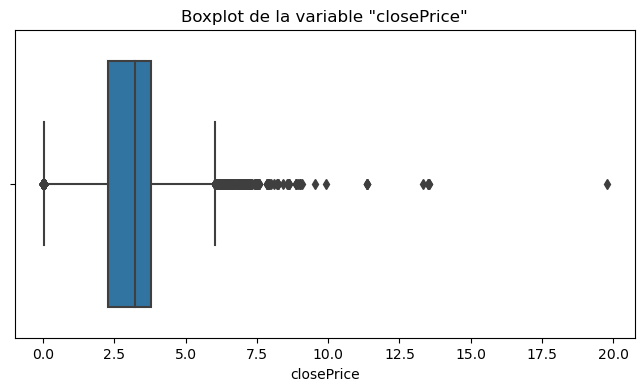

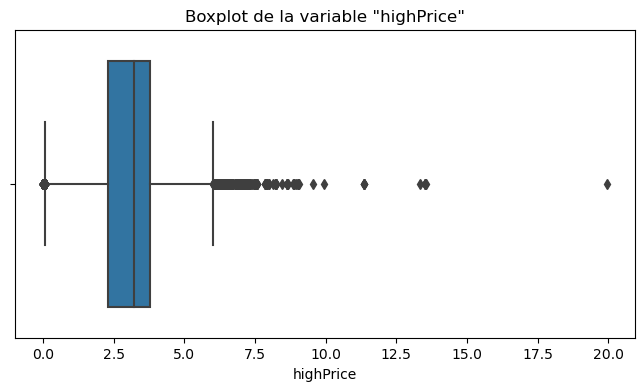

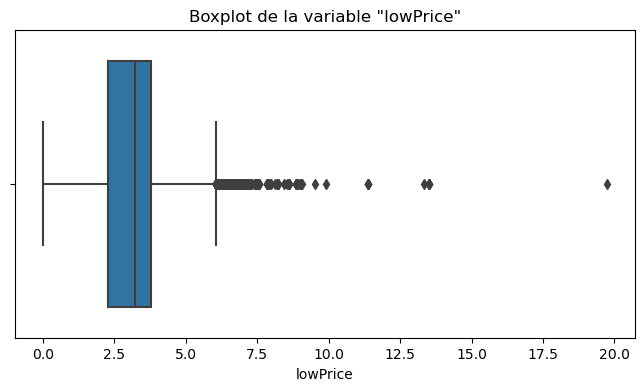

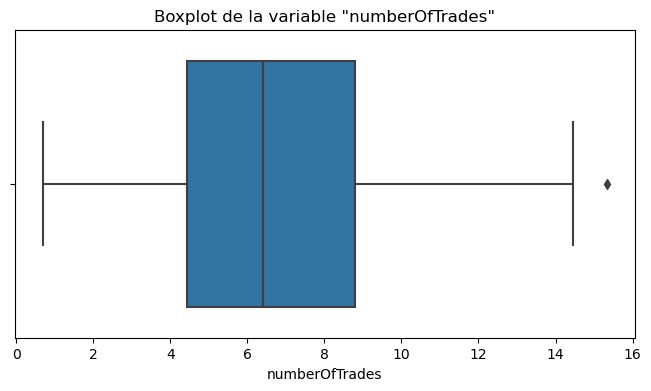

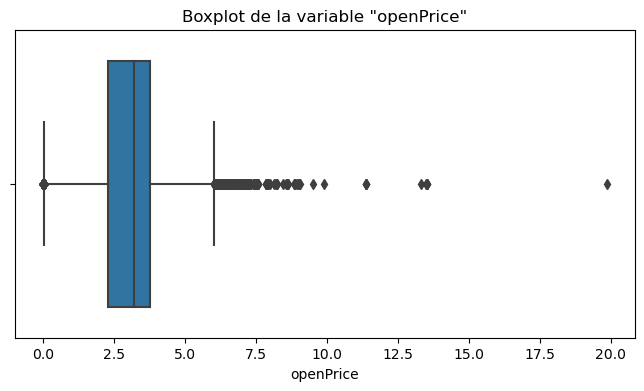

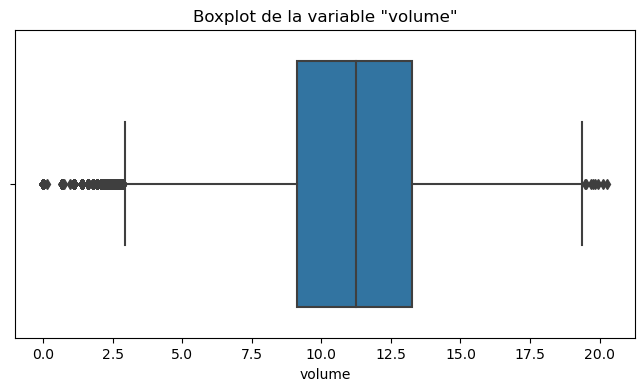

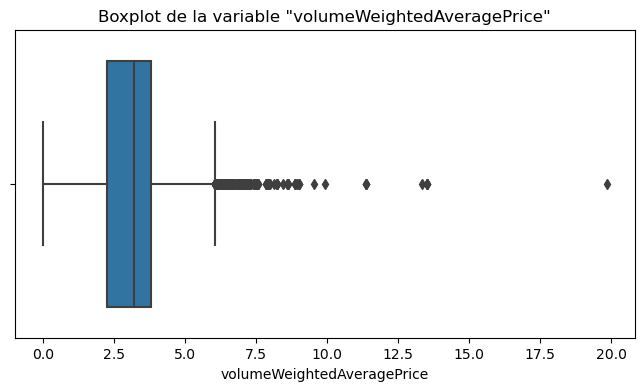

In [51]:
# Génération des boxplots pour chaque variable numérique sur des graphiques séparés
variables = [
    'closePrice',
    'highPrice',
    'lowPrice',
    'numberOfTrades',
    'openPrice',
    'volume',
    'volumeWeightedAveragePrice'
]

for col in variables:
    plt.figure(figsize=(8, 4))
    sns.boxplot(x=np.log1p(df[col]))
    plt.title(f'Boxplot de la variable "{col}"')
    plt.xlabel(f'{col}')
    plt.show()


## Analyse des corrélations entre les variables

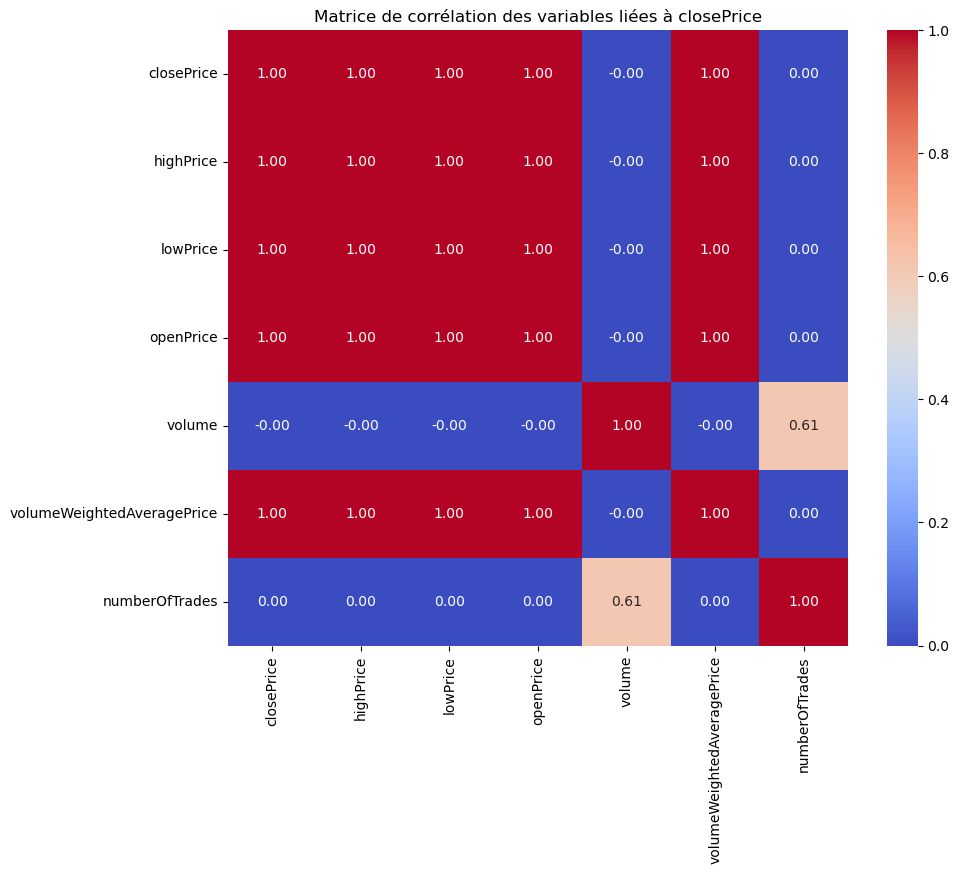

In [52]:
# Sélection des variables numériques
num_vars = ['closePrice', 'highPrice', 'lowPrice', 'openPrice', 'volume', 'volumeWeightedAveragePrice', 'numberOfTrades']
df_num = df[num_vars]

# Génération de la heatmap de corrélation
plt.figure(figsize=(10, 8))
sns.heatmap(df_num.corr(numeric_only=True), cmap='coolwarm', annot=True, fmt=".2f")
plt.title('Matrice de corrélation des variables liées à closePrice')
plt.show()

# Modélisation

#### Suppression des valeurs aberrantes (outliers)

In [53]:
# Suppression des outliers
def remove_outliers_iqr(df, columns):
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
    return df

df = remove_outliers_iqr(df, ['volume', 'closePrice'])

### Normalisation des données

In [54]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df[['volume']] = scaler.fit_transform(df[['volume']])

# Choix des algorithmes de modélisation


📌 Modèle : Linear Regression
ℹ️ RMSE réel : 1194.4432 | R² réel : -0.0012
✅ RMSE Test : 1.2725
✅ R² Test : 0.0135


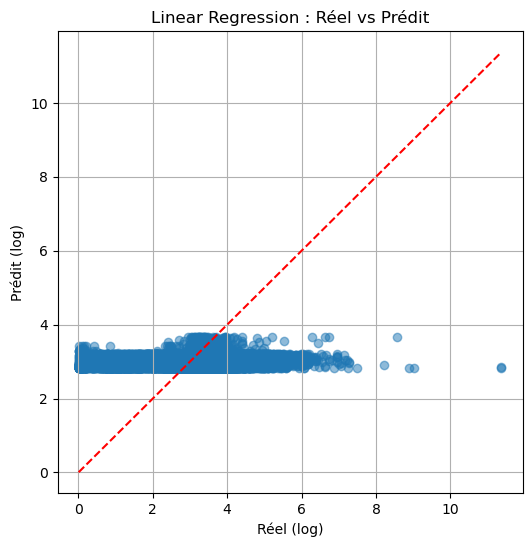


📌 Modèle : Lasso
ℹ️ RMSE réel : 1194.4368 | R² réel : -0.0012
✅ RMSE Test : 1.2748
✅ R² Test : 0.0098


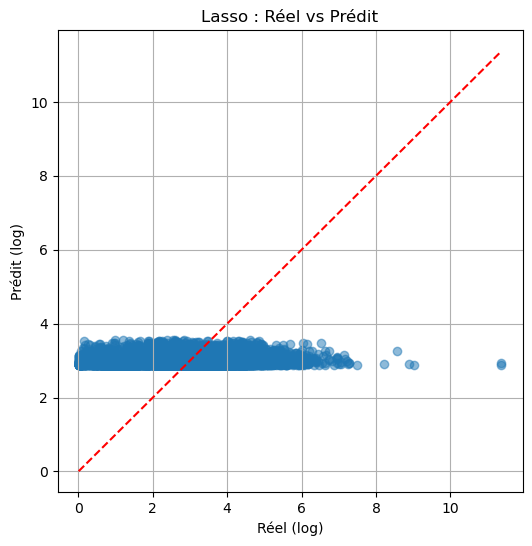


📌 Modèle : Ridge
ℹ️ RMSE réel : 1194.4411 | R² réel : -0.0012
✅ RMSE Test : 1.2726
✅ R² Test : 0.0132


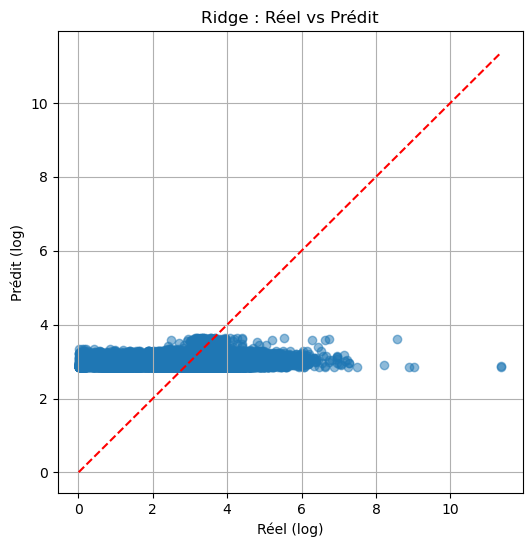


📌 Modèle : ElasticNet
ℹ️ RMSE réel : 1194.4368 | R² réel : -0.0012
✅ RMSE Test : 1.2748
✅ R² Test : 0.0099


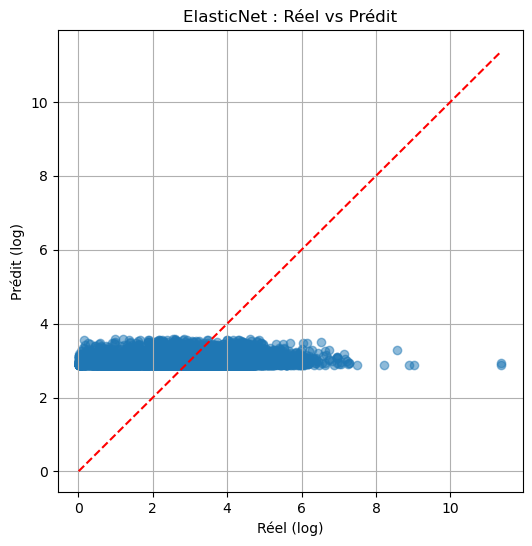


📌 Modèle : Decision Tree
ℹ️ RMSE réel : 1199.4013 | R² réel : -0.0095
✅ RMSE Test : 1.7633
✅ R² Test : -0.8945


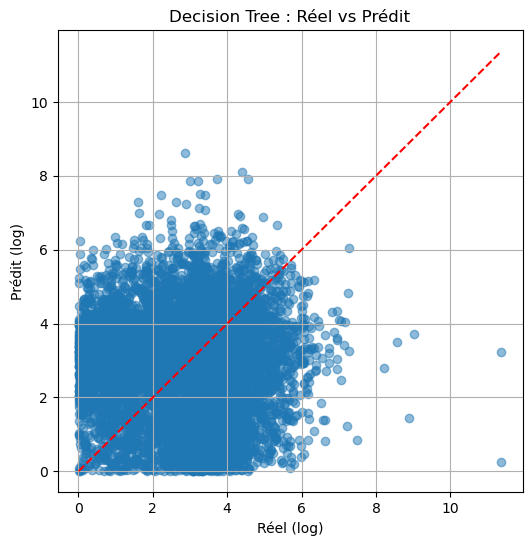


📌 Modèle : Random Forest
ℹ️ RMSE réel : 1194.8418 | R² réel : -0.0019
✅ RMSE Test : 1.5284
✅ R² Test : -0.4233


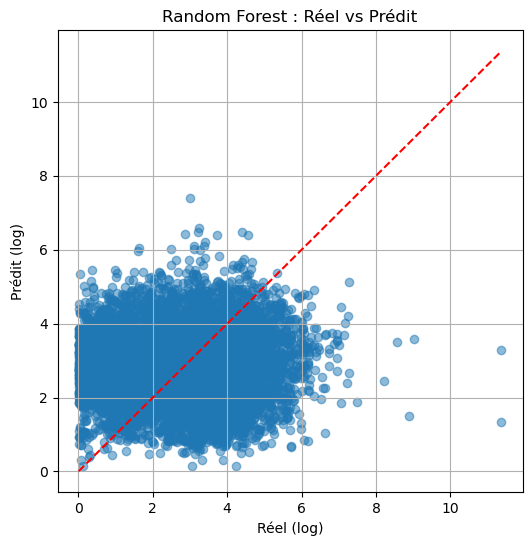


📌 Modèle : Gradient Boosting
ℹ️ RMSE réel : 1194.4184 | R² réel : -0.0011
✅ RMSE Test : 1.2675
✅ R² Test : 0.0211


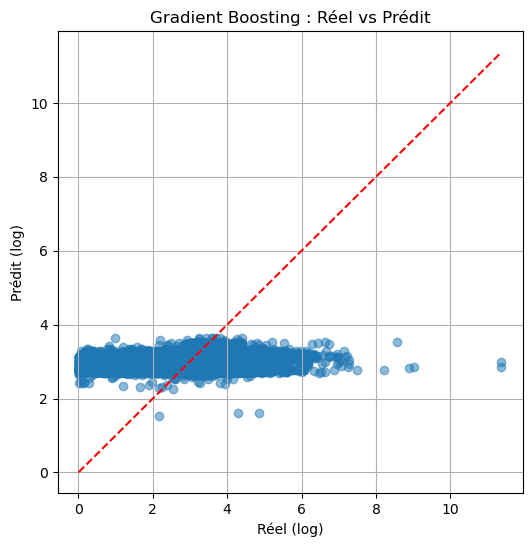


📌 Modèle : HistGradientBoosting
ℹ️ RMSE réel : 1194.4233 | R² réel : -0.0011
✅ RMSE Test : 1.2689
✅ R² Test : 0.0190


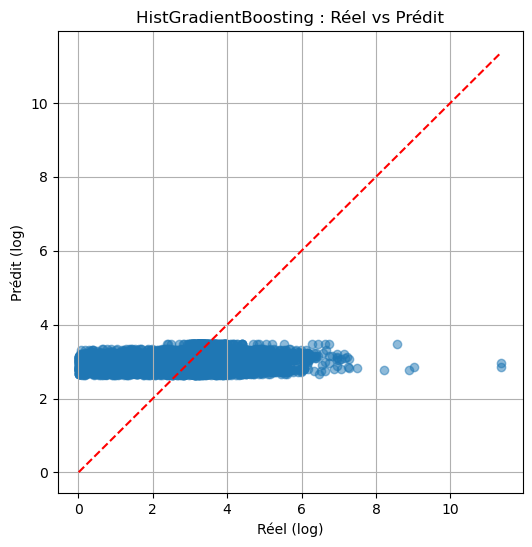


📌 Modèle : XGBoost
ℹ️ RMSE réel : 1194.4086 | R² réel : -0.0011
✅ RMSE Test : 1.2709
✅ R² Test : 0.0159


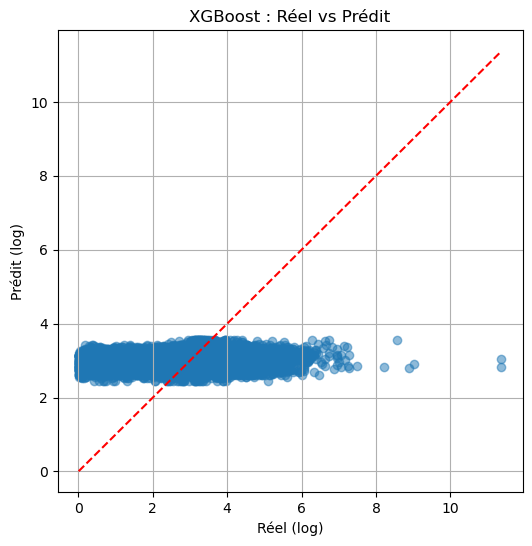


📌 Modèle : CatBoost
ℹ️ RMSE réel : 1194.4178 | R² réel : -0.0011
✅ RMSE Test : 1.2700
✅ R² Test : 0.0173


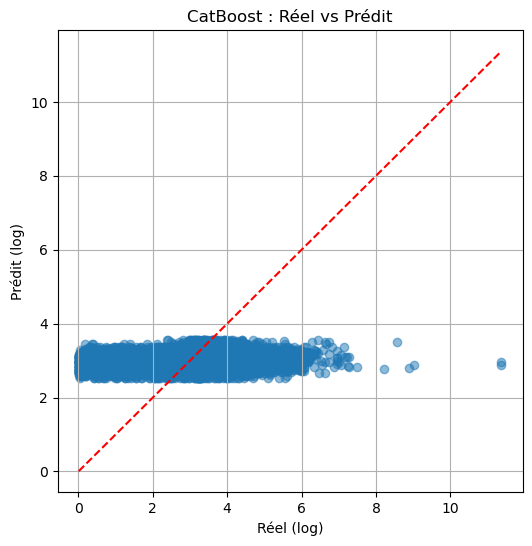


📌 Modèle : SVR (standardisé)
ℹ️ RMSE réel : 1194.2871 | R² réel : -0.0009
✅ R² CV : -0.0037 ± 0.0010
✅ RMSE Test : 1.2806
✅ R² Test : 0.0008

📌 Modèle : KNN (standardisé)
ℹ️ RMSE réel : 1194.2564 | R² réel : -0.0009
✅ R² CV : -0.1613 ± 0.0004
✅ RMSE Test : 1.3851
✅ R² Test : -0.1689

📌 Modèle : MLP (standardisé)
ℹ️ RMSE réel : 1194.4327 | R² réel : -0.0012
✅ R² CV : 0.0175 ± 0.0007
✅ RMSE Test : 1.2700
✅ R² Test : 0.0173

📊 Résultats finaux :
                  Modèle   R² CV  STD CV  RMSE Test  R² Test
6      Gradient Boosting  0.0198  0.0002     1.2675   0.0211
7   HistGradientBoosting  0.0180  0.0002     1.2689   0.0190
9               CatBoost  0.0145  0.0007     1.2700   0.0173
12                   MLP  0.0175  0.0007     1.2700   0.0173
8                XGBoost  0.0128  0.0016     1.2709   0.0159
0      Linear Regression  0.0136  0.0004     1.2725   0.0135
2                  Ridge  0.0129  0.0005     1.2726   0.0132
3             ElasticNet  0.0098  0.0003     1.2748   0.0099
1  

C:\Users\KABRE\AppData\Local\Temp\ipykernel_19440\773098288.py:149: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from current font.
  plt.tight_layout()
C:\Users\KABRE\anaconda3\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


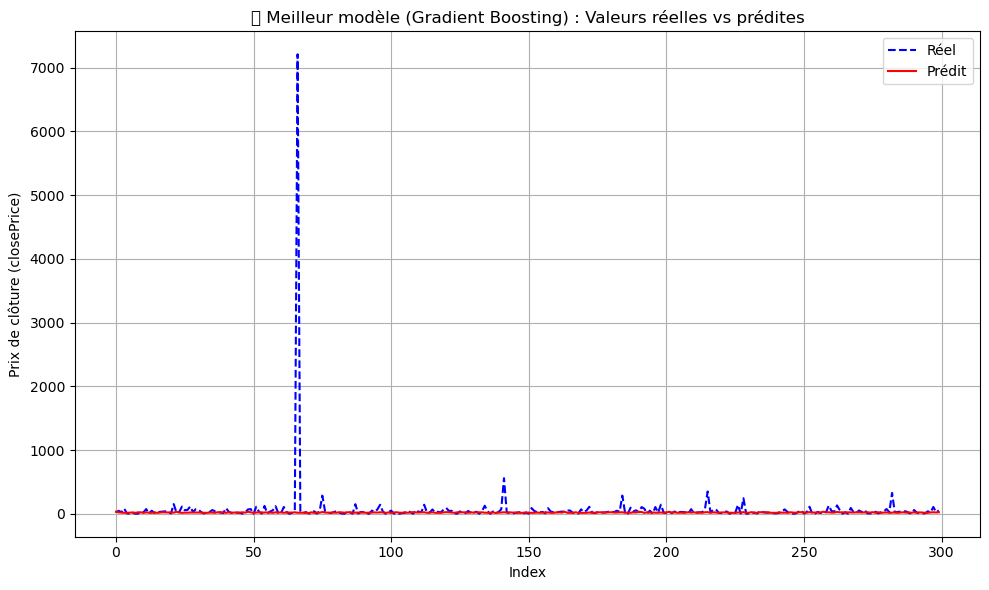

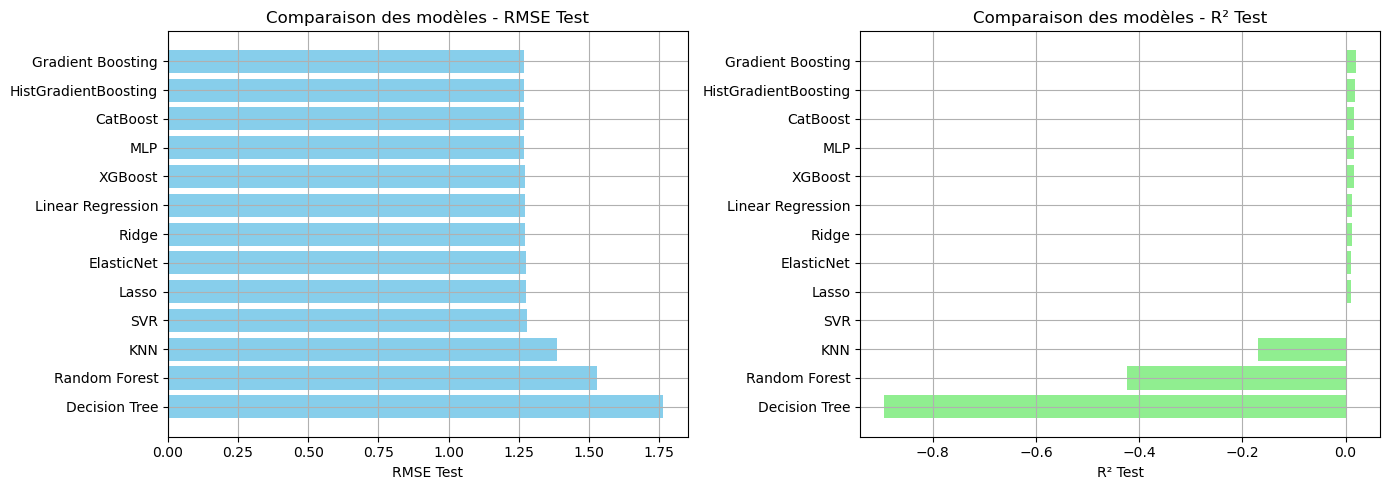

In [55]:
df.dropna(subset=['volume', 'closePrice'], inplace=True)
scaler = StandardScaler()
df_filtered = df[(df['volume'] > df['volume'].quantile(0.01)) & 
                 (df['volume'] < df['volume'].quantile(0.99))].copy()

df_filtered['log_volume'] = np.log1p(df_filtered['volume'])
df_filtered['log_closePrice'] = np.log1p(df_filtered['closePrice'])

df_filtered['log_volume_sq'] = df_filtered['log_volume'] ** 2
df_filtered['log_volume_cub'] = df_filtered['log_volume'] ** 3
df_filtered['sqrt_log_volume'] = np.sqrt(df_filtered['log_volume'])

X = df_filtered[['log_volume', 'log_volume_sq', 'log_volume_cub', 'sqrt_log_volume']]
y = df_filtered['log_closePrice']

df_model = pd.concat([X, y], axis=1).dropna()
X = df_model[X.columns]
y = df_model[y.name]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# ======================================
# Fonctions
# ======================================

def evaluate_model(model, X, y):
    kf = KFold(n_splits=2, shuffle=True, random_state=42)
    scores = cross_val_score(model, X, y, cv=kf, scoring='r2')
    return scores.mean(), scores.std()

def test_metrics(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    rmse_log = np.sqrt(mean_squared_error(y_test, y_pred))
    r2_log = r2_score(y_test, y_pred)

    y_test_real = np.expm1(y_test)
    y_pred_real = np.expm1(y_pred)
    rmse_real = np.sqrt(mean_squared_error(y_test_real, y_pred_real))
    r2_real = r2_score(y_test_real, y_pred_real)
    
    print(f"ℹ️ RMSE réel : {rmse_real:.4f} | R² réel : {r2_real:.4f}")
    
    return rmse_log, r2_log, y_pred, y_test_real, y_pred_real

def plot_predictions(y_test, y_pred, model_name):
    plt.figure(figsize=(6, 6))
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.xlabel('Réel (log)')
    plt.ylabel('Prédit (log)')
    plt.title(f'{model_name} : Réel vs Prédit')
    plt.grid(True)
    plt.show()

# ======================================
# Modèles
# ======================================

models_unscaled = {
    "Linear Regression": LinearRegression(),
    "Lasso": Lasso(alpha=0.1),
    "Ridge": Ridge(alpha=1.0),
    "ElasticNet": ElasticNet(alpha=0.1, l1_ratio=0.5),
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42),
    "HistGradientBoosting": HistGradientBoostingRegressor(random_state=42),
    "XGBoost": xgb.XGBRegressor(random_state=42),
    "CatBoost": CatBoostRegressor(verbose=0, random_state=42),
}

models_scaled = {
    "SVR": SVR(),
    "KNN": KNeighborsRegressor(),
    "MLP": MLPRegressor(random_state=42, max_iter=500)
}

# ======================================
# Évaluation
# ======================================

results = []
predictions_dict = {}  # ✅ Ajouté ici

for name, model in models_unscaled.items():
    print(f"\n📌 Modèle : {name}")
    try:
        r2_cv, std_cv = evaluate_model(model, X, y)
        rmse_test, r2_test, y_pred, y_real, y_pred_real = test_metrics(model, X_train, X_test, y_train, y_test)
        print(f"✅ RMSE Test : {rmse_test:.4f}")
        print(f"✅ R² Test : {r2_test:.4f}")
        plot_predictions(y_test, y_pred, name)
        results.append({
            "Modèle": name,
            "R² CV": round(r2_cv, 4),
            "STD CV": round(std_cv, 4),
            "RMSE Test": round(rmse_test, 4),
            "R² Test": round(r2_test, 4)
        })
        predictions_dict[name] = (y_real, y_pred_real)
    except Exception as e:
        print(f"⚠️ Erreur avec {name} : {e}")

for name, model in models_scaled.items():
    print(f"\n📌 Modèle : {name} (standardisé)")
    try:
        r2_cv, std_cv = evaluate_model(model, scaler.transform(X), y)
        rmse_test, r2_test, y_pred, y_real, y_pred_real = test_metrics(model, X_train_scaled, X_test_scaled, y_train, y_test)
        print(f"✅ R² CV : {r2_cv:.4f} ± {std_cv:.4f}")
        print(f"✅ RMSE Test : {rmse_test:.4f}")
        print(f"✅ R² Test : {r2_test:.4f}")
        results.append({
            "Modèle": name,
            "R² CV": round(r2_cv, 4),
            "STD CV": round(std_cv, 4),
            "RMSE Test": round(rmse_test, 4),
            "R² Test": round(r2_test, 4)
        })
        predictions_dict[name] = (y_real, y_pred_real)
    except Exception as e:
        print(f"⚠️ Erreur avec {name} (standardisé) : {e}")

# ==============================
# Résultats & Visualisation
# ==============================

results_df = pd.DataFrame(results).sort_values(by="R² Test", ascending=False)
print("\n📊 Résultats finaux :")
print(results_df)

# 🔍 Comparatif réel vs prédit du meilleur modèle
best_model = results_df.iloc[0]['Modèle']
best_y_real, best_y_pred = predictions_dict[best_model]

plt.figure(figsize=(10, 6))
plt.plot(best_y_real.values[:300], label='Réel', color='blue', linestyle='--')
plt.plot(best_y_pred[:300], label='Prédit', color='red')
plt.title(f"🔍 Meilleur modèle ({best_model}) : Valeurs réelles vs prédites")
plt.xlabel("Index")
plt.ylabel("Prix de clôture (closePrice)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Barplots
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

results_df_sorted = results_df.sort_values("RMSE Test")
axes[0].barh(results_df_sorted["Modèle"], results_df_sorted["RMSE Test"], color='skyblue')
axes[0].set_xlabel("RMSE Test")
axes[0].set_title("Comparaison des modèles - RMSE Test")
axes[0].invert_yaxis()
axes[0].grid(True)

results_df_sorted = results_df.sort_values("R² Test", ascending=False)
axes[1].barh(results_df_sorted["Modèle"], results_df_sorted["R² Test"], color='lightgreen')
axes[1].set_xlabel("R² Test")
axes[1].set_title("Comparaison des modèles - R² Test")
axes[1].invert_yaxis()
axes[1].grid(True)

plt.tight_layout()
plt.show()

# meilleur algorithme : Gradient Boosting 


📌 Modèle : Gradient Boosting
✅ R² CV       : 0.0198 ± 0.0002
✅ RMSE  : 1194.4184
✅ MAE   : 49.7503
✅ R²    : 0.0211


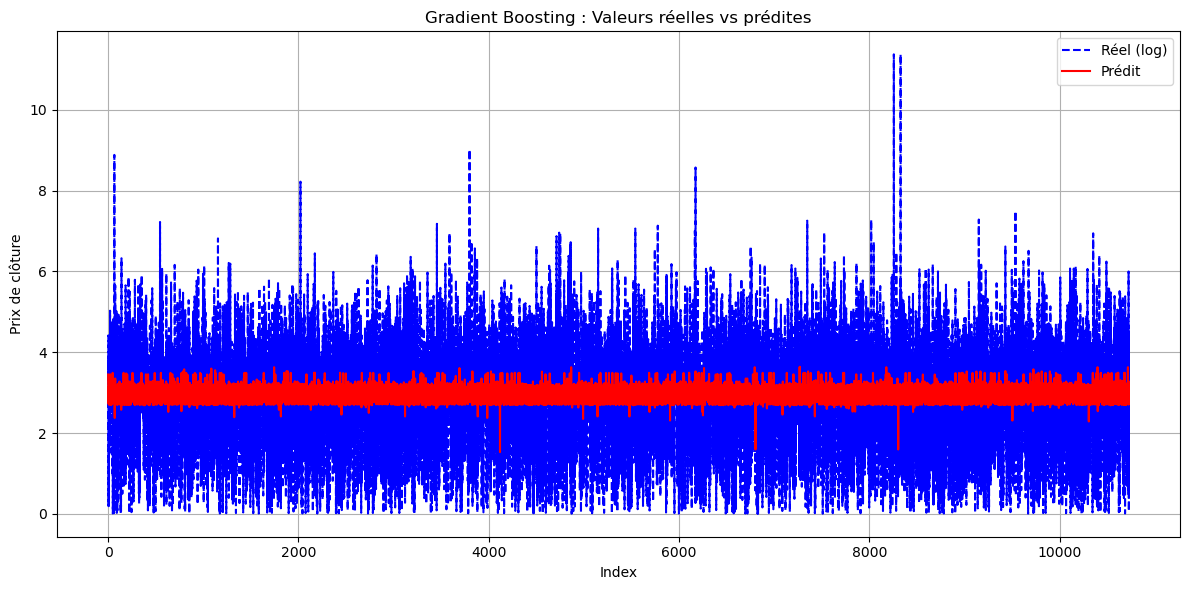

In [105]:
df.dropna(subset=['volume', 'closePrice'], inplace=True)

df_filtered = df[(df['volume'] > df['volume'].quantile(0.01)) & 
                 (df['volume'] < df['volume'].quantile(0.99))].copy()

df_filtered['log_volume'] = np.log1p(df_filtered['volume'])
df_filtered['log_closePrice'] = np.log1p(df_filtered['closePrice'])

df_filtered['log_volume_sq'] = df_filtered['log_volume'] ** 2
df_filtered['log_volume_cub'] = df_filtered['log_volume'] ** 3
df_filtered['sqrt_log_volume'] = np.sqrt(df_filtered['log_volume'])

X = df_filtered[['log_volume', 'log_volume_sq', 'log_volume_cub', 'sqrt_log_volume']]
y = df_filtered['log_closePrice']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ======================================
# Fonctions utiles
# ======================================

def evaluate_model(model, X, y):
    kf = KFold(n_splits=2, shuffle=True, random_state=42)
    scores = cross_val_score(model, X, y, cv=kf, scoring='r2')
    return scores.mean(), scores.std()

def test_metrics(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    rmse_log = np.sqrt(mean_squared_error(y_test, y_pred))
    r2_log = r2_score(y_test, y_pred)
    mae_log = mean_absolute_error(y_test, y_pred)

    y_test_real = np.expm1(y_test)
    y_pred_real = np.expm1(y_pred)

    rmse_real = np.sqrt(mean_squared_error(y_test_real, y_pred_real))
    r2_real = r2_score(y_test_real, y_pred_real)
    mae_real = mean_absolute_error(y_test_real, y_pred_real)

    return rmse_log, r2_log, mae_log, rmse_real, r2_real, mae_real, y_pred, y_test_real, y_pred_real

# ======================================
# Modèle Gradient Boosting uniquement
# ======================================

model_name = "Gradient Boosting"
model = GradientBoostingRegressor(random_state=42)

print(f"\n📌 Modèle : {model_name}")

r2_cv, std_cv = evaluate_model(model, X, y)
rmse_log, r2_log, mae_log, rmse_real, r2_real, mae_real, y_pred, y_real, y_pred_real = test_metrics(
    model, X_train, X_test, y_train, y_test
)

print(f"✅ R² CV       : {r2_cv:.4f} ± {std_cv:.4f}")
print(f"✅ RMSE  : {rmse_real:.4f}")
print(f"✅ MAE   : {mae_real:.4f}")
print(f"✅ R²    : {r2_log:.4f}")


# ==============================
# Visualisation : réel vs prédit
# ==============================
plt.figure(figsize=(12, 6))
plt.plot(y_test.reset_index(drop=True), label='Réel (log)', color='blue', linestyle='--')
plt.plot(pd.Series(y_pred).reset_index(drop=True), label='Prédit', color='red')
plt.title(f"{model_name} : Valeurs réelles vs prédites")
plt.xlabel("Index")
plt.ylabel("Prix de clôture")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# Vers un meilleur modèle prédictif de closePrice 


📌 Modèle : Gradient Boosting
✅ R² CV       : 0.9299 ± 0.0018
✅ RMSE  : 0.3339
✅ MAE   : 0.2529
✅ R²    : 0.9321


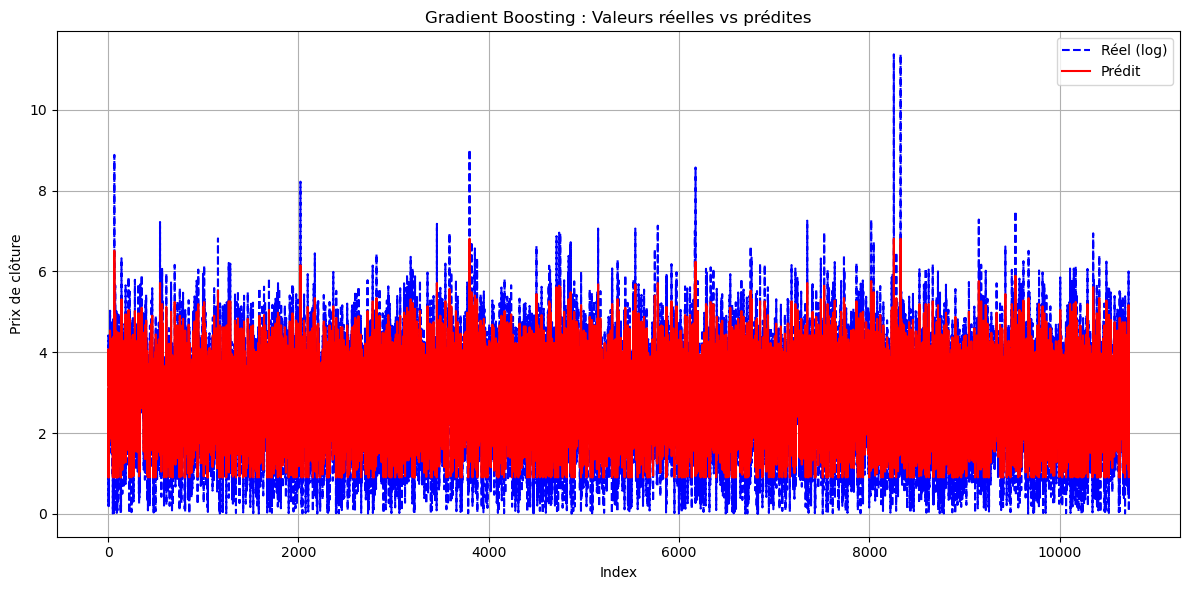

In [120]:
# Transformation logarithmique
df_filtered['log_closePrice'] = np.log1p(df_filtered['closePrice'])

# Sélection des features
features = ['volume', 'highPrice', 'lowPrice', 'openPrice']
target = 'log_closePrice'

X = df_filtered[features]
y = df_filtered[target]


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ======================================
# Fonctions utiles
# ======================================

def evaluate_model(model, X, y):
    kf = KFold(n_splits=2, shuffle=True, random_state=42)
    scores = cross_val_score(model, X, y, cv=kf, scoring='r2')
    return scores.mean(), scores.std()

def test_metrics(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    rmse_log = np.sqrt(mean_squared_error(y_test, y_pred))
    r2_log = r2_score(y_test, y_pred)
    mae_log = mean_absolute_error(y_test, y_pred)

    y_test_real = np.expm1(y_test)
    y_pred_real = np.expm1(y_pred)

    rmse_real = np.sqrt(mean_squared_error(y_test_real, y_pred_real))
    r2_real = r2_score(y_test_real, y_pred_real)
    mae_real = mean_absolute_error(y_test_real, y_pred_real)

    return rmse_log, r2_log, mae_log, rmse_real, r2_real, mae_real, y_pred, y_test_real, y_pred_real

# ======================================
# Modèle Gradient Boosting uniquement
# ======================================

model_name = "Gradient Boosting"

model = GradientBoostingRegressor(
    n_estimators=70,
    learning_rate=0.02,
    max_depth=3,
    min_samples_split=15,
    min_samples_leaf=10,
    subsample=0.8,
    random_state=42
)



print(f"\n📌 Modèle : {model_name}")

r2_cv, std_cv = evaluate_model(model, X, y)
rmse_log, r2_log, mae_log, rmse_real, r2_real, mae_real, y_pred, y_real, y_pred_real = test_metrics(
    model, X_train, X_test, y_train, y_test
)

print(f"✅ R² CV       : {r2_cv:.4f} ± {std_cv:.4f}")
print(f"✅ RMSE  : {rmse_log:.4f}")
print(f"✅ MAE   : {mae_log:.4f}")
print(f"✅ R²    : {r2_log:.4f}")


# ==============================
# Visualisation : réel vs prédit
# ==============================
plt.figure(figsize=(12, 6))
plt.plot(y_test.reset_index(drop=True), label='Réel (log)', color='blue', linestyle='--')
plt.plot(pd.Series(y_pred).reset_index(drop=True), label='Prédit', color='red')
plt.title(f"{model_name} : Valeurs réelles vs prédites")
plt.xlabel("Index")
plt.ylabel("Prix de clôture")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# Sauvegardons le modèle entraîné

In [58]:
import joblib
import os

# Créer le dossier s'il n'existe pas
os.makedirs("models", exist_ok=True)

# Sauvegarde du modèle entraîné
joblib.dump(model, "models/gradient_boosting_model.pkl")
print("✅ Modèle sauvegardé sous : models/gradient_boosting_model.pkl")


✅ Modèle sauvegardé sous : models/gradient_boosting_model.pkl
